https://www.kaggle.com/code/sugghi/training-3rd-place-solution/notebook
ここのソリューションをBybitで実装してみる。

変更点：
    ・　通貨ペアーは取引の多いものを選ぶ（１４まで選ぶと１分足が作れない可能性があるため減らす）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime

import pickle
import gc

from tqdm import tqdm

In [2]:
n_fold = 7
seed0 = 8586

In [3]:
# そのままコピー
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
import rbot

bb_btcusd = rbot.DummyBb()
bb_btcusd.market_type = "BTCUSD"
bb_btcusdt = rbot.DummyBb()
bb_btcusdt.market_type = "BTCUSDT"

bb_ethusd = rbot.DummyBb()
bb_ethusd.market_type = "ETHUSD"
bb_ethusdt = rbot.DummyBb()
bb_ethusdt.market_type = "ETHUSDT"

bb_xrpusdt = rbot.DummyBb()
bb_xrpusdt.market_type = "XRPUSDT"
bb_xrpusd = rbot.DummyBb()
bb_xrpusd.market_type = "XRPUSD"

bb_solusdt = rbot.DummyBb()
bb_solusdt.market_type = "SOLUSDT"


In [6]:
# 注意　１０GB レベルでDiskを消費します。
# 2回目は LOAD_NEWをFalseにするとダンプファイルからロードするので高速です。
LOAD_NEW = True
LOAD_DAYS = 100

if LOAD_NEW:
    bb_btcusd.log_load(LOAD_DAYS)
    bb_btcusd.dump()
    bb_btcusdt.log_load(LOAD_DAYS)
    bb_btcusdt.dump()
    bb_ethusd.log_load(LOAD_DAYS)
    bb_ethusd.dump()
    bb_ethusdt.log_load(LOAD_DAYS)
    bb_ethusdt.dump()
    bb_xrpusd.log_load(LOAD_DAYS)
    bb_xrpusd.dump()
    bb_xrpusdt.log_load(LOAD_DAYS)
    bb_xrpusdt.dump()
    bb_solusdt.log_load(LOAD_DAYS)
    bb_solusdt.dump()
else:
    bb_btcusd.restore()
    bb_btcusdt.restore()
    bb_ethusd.restore()
    bb_ethusdt.restore()
    bb_xrpusd.restore()
    bb_xrpusdt.restore()
    bb_solusdt.restore()


In [103]:
OFFSET_PERIOD = 15
#OFFSET_PERIOD = 15

# diff の方向はマイナスが正しい。
def log_return(series, periods=OFFSET_PERIOD):
    return np.log(series).diff(periods= - periods)

def calc_mean(x):
    if len(x['price'])== 0:
        return pd.NA

    return np.average(x['price'], weights=x['size'])    


# Closeのログリターンを計算する（Closeでいいのかな？）
def make_df(dummy_bb, asset_id):
    raw_df = rbot.rawlog_to_df(dummy_bb.raw_log(0, 0))

    df = raw_df['price'].resample('1T').ohlc()
    df['mean_price'] = raw_df.resample('1T').apply(calc_mean)
    df['Asset_ID'] = asset_id
    df = df.fillna(method='ffill')
    df['Target'] = log_return(df['mean_price'])

    del raw_df

    return df

In [139]:
df_btcusd = make_df(bb_btcusd, 0)
df_btcusdt = make_df(bb_btcusdt, 1)
df_ethusd = make_df(bb_ethusd, 2)
df_ethusdt = make_df(bb_ethusdt, 3)
df_xrpusd = make_df(bb_xrpusd, 4)
df_xrpusdt = make_df(bb_xrpusdt, 5)
df_solusdt = make_df(bb_solusdt, 6)

df_train = pd.concat([df_btcusd, df_btcusdt, df_ethusd, df_ethusdt, df_xrpusd, df_xrpusdt, df_solusdt])
df_train = reduce_mem_usage(df_train)
df_train

Memory usage of dataframe is 61.52 MB
Memory usage after optimization is: 20.19 MB
Decreased by 67.2%


,open,high,low,close,mean_price,Asset_ID,Target
timestamp,,,,,,,
2022-03-31 00:00:00+00:00,47040.00000,47072.00000,46976.00000,47008.00000,47040.00000,0,-0.002069
2022-03-31 00:01:00+00:00,47008.00000,47008.00000,46976.00000,46976.00000,46976.00000,0,-0.003273
2022-03-31 00:02:00+00:00,46976.00000,47040.00000,46976.00000,47008.00000,47040.00000,0,-0.002497
2022-03-31 00:03:00+00:00,47008.00000,47040.00000,47008.00000,47008.00000,47040.00000,0,-0.002201
2022-03-31 00:04:00+00:00,47008.00000,47040.00000,47008.00000,47008.00000,47008.00000,0,-0.002329
...,...,...,...,...,...,...,...
2022-07-08 23:55:00+00:00,38.37500,38.40625,38.37500,38.37500,38.37500,6,NaN
2022-07-08 23:56:00+00:00,38.37500,38.37500,38.12500,38.15625,38.21875,6,NaN
2022-07-08 23:57:00+00:00,38.15625,38.18750,38.00000,38.00000,38.06250,6,NaN


In [140]:
df_train['timestamp'] = df_train.index.astype('int64')
#df_train['Close'] = df_train["close"] 
df_train['Close'] = (df_train["open"] + df_train["close"] + df_train["high"] + df_train["low"])/4
df_train = df_train.reset_index(drop=True)
df_train = reduce_mem_usage(df_train)
df_train


Memory usage of dataframe is 22.11 MB
Memory usage after optimization is: 27.88 MB
Decreased by -26.1%


,open,high,low,close,mean_price,Asset_ID,Target,timestamp,Close
0,47040.00000,47072.00000,46976.00000,47008.00000,47040.00000,0,-0.002069,1648684800000000000,inf
1,47008.00000,47008.00000,46976.00000,46976.00000,46976.00000,0,-0.003273,1648684860000000000,inf
2,46976.00000,47040.00000,46976.00000,47008.00000,47040.00000,0,-0.002497,1648684920000000000,inf
3,47008.00000,47040.00000,47008.00000,47008.00000,47040.00000,0,-0.002201,1648684980000000000,inf
4,47008.00000,47040.00000,47008.00000,47008.00000,47008.00000,0,-0.002329,1648685040000000000,inf
...,...,...,...,...,...,...,...,...,...
1007995,38.37500,38.40625,38.37500,38.37500,38.37500,6,NaN,1657324500000000000,38.37500
1007996,38.37500,38.37500,38.12500,38.15625,38.21875,6,NaN,1657324560000000000,38.25000
1007997,38.15625,38.18750,38.00000,38.00000,38.06250,6,NaN,1657324620000000000,38.06250
1007998,38.00000,38.09375,37.96875,38.03125,38.00000,6,NaN,1657324680000000000,38.03125


In [141]:
NUM_OF_ASSETS = 7

train_merged = pd.DataFrame()
train_merged[df_train.columns] = 0
for id in tqdm( range(NUM_OF_ASSETS) ):
    train_merged = train_merged.merge(df_train.loc[df_train["Asset_ID"] == id, ['timestamp', 'Close','Target']].copy(), on="timestamp", how='outer',suffixes=['', "_"+str(id)])
        
train_merged = train_merged.drop(df_train.columns.drop("timestamp"), axis=1)
train_merged = train_merged.sort_values('timestamp', ascending=True)
display(train_merged.head())


100%|██████████| 7/7 [00:00<00:00, 35.10it/s]


,timestamp,Close_0,Target_0,Close_1,Target_1,Close_2,Target_2,Close_3,Target_3,Close_4,Target_4,Close_5,Target_5,Close_6,Target_6
0,1648684800000000000,inf,-0.002069,inf,-0.002342,3380.0,-0.003893,3380.0,-0.003819,0.861328,-0.002249,0.861328,-0.002333,120.6250,-0.003885
1,1648684860000000000,inf,-0.003273,inf,-0.002928,3378.0,-0.005798,3376.0,-0.005001,0.860352,-0.002653,0.860352,-0.002651,120.3750,-0.005692
2,1648684920000000000,inf,-0.002497,inf,-0.002764,3378.0,-0.005199,3378.0,-0.004883,0.859375,-0.004414,0.859375,-0.004566,120.3125,-0.005905
3,1648684980000000000,inf,-0.002201,inf,-0.002323,3380.0,-0.003725,3380.0,-0.003696,0.859375,-0.003578,0.859375,-0.003769,120.3125,-0.005089
4,1648685040000000000,inf,-0.002329,inf,-0.002373,3380.0,-0.003883,3380.0,-0.003811,0.859863,-0.003435,0.859863,-0.003622,120.1875,-0.005280


In [142]:
for id in range(NUM_OF_ASSETS):
    # print(id, train_merged[f'Close_{id}'].isnull().sum())   # Number of missing before forward fill
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].astype('object').fillna(method='ffill', limit=100)
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].astype('float64')


In [143]:
lags = [60,300,900]
#lags = [15,30, 60, 120, 240, 480]

def get_features(df, train=True):   
    if train == True:
        totimestamp = lambda s: np.int32(time.mktime(datetime.datetime.strptime(s, "%d/%m/%Y").timetuple()))
        valid_window = [totimestamp("12/03/2021")]
#         valid_window = [totimestamp("15/08/2021")]  #検証用
        df['train_flg'] = np.where(df['timestamp']>=valid_window[0], 0,1)

        supple_start_window = [totimestamp("22/09/2021")]

        #if use_supple_for_train:
        # USE IT!!
        #df['train_flg'] = np.where(df['timestamp']>=supple_start_window[0], 1 ,df['train_flg']  )
   
    for id in range(NUM_OF_ASSETS):    
        for lag in lags:
            df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
            df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
    for lag in lags:
        df[f'mean_close/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_close/mean_{lag}_id')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}_id')] ,    axis=1)
        for id in range(NUM_OF_ASSETS):
            df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )
            df[f'log_return_{lag}-mean_log_returns_{lag}_id{id}']    = np.array( df[f'log_return_{lag}_id{id}'])     - np.array( df[f'mean_log_returns_{lag}'] )

    if train == True:
        for id in range(NUM_OF_ASSETS):
            df = df.drop([f'Close_{id}'], axis=1)
        oldest_use_window = [totimestamp("12/01/2019")]
        df = df[  df['timestamp'] >= oldest_use_window[0]   ]

    return df

In [144]:
feat = get_features(train_merged)
feat

/var/folders/5r/xmxmz7gj2cjcb7d65tgwvrt40000gn/T/ipykernel_92492/449803766.py:19: RuntimeWarning: invalid value encountered in true_divide
  df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
/var/folders/5r/xmxmz7gj2cjcb7d65tgwvrt40000gn/T/ipykernel_92492/449803766.py:20: RuntimeWarning: invalid value encountered in true_divide
  df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
/var/folders/5r/xmxmz7gj2cjcb7d65tgwvrt40000gn/T/ipykernel_92492/449803766.py:25: RuntimeWarning: invalid value encountered in subtract
  df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )


,timestamp,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,train_flg,log_close/mean_60_id0,...,log_close/mean_900-mean_close/mean_900_id2,log_return_900-mean_log_returns_900_id2,log_close/mean_900-mean_close/mean_900_id3,log_return_900-mean_log_returns_900_id3,log_close/mean_900-mean_close/mean_900_id4,log_return_900-mean_log_returns_900_id4,log_close/mean_900-mean_close/mean_900_id5,log_return_900-mean_log_returns_900_id5,log_close/mean_900-mean_close/mean_900_id6,log_return_900-mean_log_returns_900_id6
0,1648684800000000000,-0.002069,-0.002342,-0.003893,-0.003819,-0.002249,-0.002333,-0.003885,0,inf,...,-inf,0.015002,-inf,0.014181,-inf,-0.102729,-inf,-0.103428,-inf,0.176974
1,1648684860000000000,-0.003273,-0.002928,-0.005798,-0.005001,-0.002653,-0.002651,-0.005692,0,inf,...,-inf,0.015503,-inf,0.013270,-inf,-0.101949,-inf,-0.101949,-inf,0.175124
2,1648684920000000000,-0.002497,-0.002764,-0.005199,-0.004883,-0.004414,-0.004566,-0.005905,0,inf,...,-inf,0.014179,-inf,0.013359,-inf,-0.100903,-inf,-0.101605,-inf,0.174971
3,1648684980000000000,-0.002201,-0.002323,-0.003725,-0.003696,-0.003578,-0.003769,-0.005089,0,inf,...,-inf,0.015467,-inf,0.014644,-inf,-0.102091,-inf,-0.102091,-inf,0.174071
4,1648685040000000000,-0.002329,-0.002373,-0.003883,-0.003811,-0.003435,-0.003622,-0.005280,0,inf,...,-inf,0.016407,-inf,0.016407,-inf,-0.103392,-inf,-0.103392,-inf,0.173971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143995,1657324500000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,-0.001974,0.005212,-0.001853,0.005208,-0.001804,-0.022278,-0.001717,-0.021564,0.007348,0.033422
143996,1657324560000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,-0.003719,0.003258,-0.002777,0.004077,-0.000759,-0.021348,0.000042,-0.019918,0.007212,0.033930
143997,1657324620000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,-0.003386,0.003751,-0.003258,0.003755,-0.000486,-0.021764,-0.000397,-0.021045,0.007527,0.035305
143998,1657324680000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,-0.003640,0.003256,-0.003511,0.004081,0.000217,-0.021574,-0.001131,-0.022293,0.008064,0.036530


In [145]:
# define features for LGBM
not_use_features_train = ['timestamp', 'train_flg']
for id in range(NUM_OF_ASSETS):
    not_use_features_train.append(f'Target_{id}')

features = feat.columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

90

In [146]:
#del train_merged
#del df_train
gc.collect()

90

In [147]:
# define the evaluation metric
def correlation(a, train_data):
    
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [148]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# (used in nyanp's Optiver solution)
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [149]:
# from: https://www.kaggle.com/code/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/
def get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750):
    all_train_timestamps = data['timestamp'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last timestamps, in case the number of timestamps wasn't divisible by cv
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage. Note timestamps are expressed in seconds, so multiply by 60
        embargo_sec = 60*embargo
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

In [150]:
def get_Xy_and_model_for_asset(df_proc, asset_id):
    df_proc = df_proc.loc[  (df_proc[f'Target_{asset_id}'] == df_proc[f'Target_{asset_id}'])  ]
    #if not_use_overlap_to_train:
    #   df_proc = df_proc.loc[  (df_proc['train_flg'] == 1)  ]
    
# EmbargoCV
    train_test_zip = get_time_series_cross_val_splits(df_proc, cv = n_fold, embargo = 3750)
    print("entering time series cross validation loop")
    importances = []
    oof_pred = []
    oof_valid = []
    
    for split, train_test_split in enumerate(train_test_zip):
        gc.collect()
        
        print(f"doing split {split+1} out of {n_fold}")
        train_split, test_split = train_test_split
        train_split_index = df_proc['timestamp'].isin(train_split)
        test_split_index = df_proc['timestamp'].isin(test_split)
    
        train_dataset = lgb.Dataset(df_proc.loc[train_split_index, features],
                                    df_proc.loc[train_split_index, f'Target_{asset_id}'].values, 
                                    feature_name = features, 
                                   )
        val_dataset = lgb.Dataset(df_proc.loc[test_split_index, features], 
                                  df_proc.loc[test_split_index, f'Target_{asset_id}'].values, 
                                  feature_name = features, 
                                 )

        print(f"number of train data: {len(df_proc.loc[train_split_index])}")
        print(f"number of val data:   {len(df_proc.loc[test_split_index])}")

        model = lgb.train(params = params,
                          train_set = train_dataset, 
                          valid_sets=[train_dataset, val_dataset],
                          valid_names=['tr', 'vl'],
                          num_boost_round = 5000,
                          verbose_eval = 100,     
                          feval = correlation,
                         )
        importances.append(model.feature_importance(importance_type='gain'))
        
        file = f'trained_model_id{asset_id}_fold{split}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print(f"Trained model was saved to 'trained_model_id{asset_id}_fold{split}.pkl'")
        print("")
            
        oof_pred += list(  model.predict(df_proc.loc[test_split_index, features])        )
        oof_valid += list(   df_proc.loc[test_split_index, f'Target_{asset_id}'].values    )
    
    
    plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))

    return oof_pred, oof_valid

In [151]:
# Weigthの計算が不明

df_asset_details = pd.DataFrame(data={
    'Asset_ID': [0, 1, 2, 3, 4, 5, 6], 
    'Weight': [1, 1, 1, 1, 1, 1, 1],
    "Asset_Name": ['BTCUSD', 'BTCUSDT', 'ETHUSD', 'ETHUSDT', 'XRPUSD', 'XRPUSDT', "SOLUSDT"],
    })
df_asset_details

,Asset_ID,Weight,Asset_Name
0,0,1,BTCUSD
1,1,1,BTCUSDT
2,2,1,ETHUSD
3,3,1,ETHUSDT
4,4,1,XRPUSD
5,5,1,XRPUSDT
6,6,1,SOLUSDT


In [152]:
params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
#     'metric': 'None',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
    }

Training model for BTCUSD           (ID=0 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123416
number of val data:   20569


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	tr's rmse: 0.00431679	tr's corr: 0.157503	vl's rmse: 0.00268829	vl's corr: 0.0234274
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold0.pkl'

doing split 2 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	tr's rmse: 0.00432092	tr's corr: 0.179802	vl's rmse: 0.00256005	vl's corr: 0.0170021
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold1.pkl'

doing split 3 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00390758	tr's corr: 0.0511792	vl's rmse: 0.00525593	vl's corr: -0.00808828
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold2.pkl'

doing split 4 out of 7
number of train data:

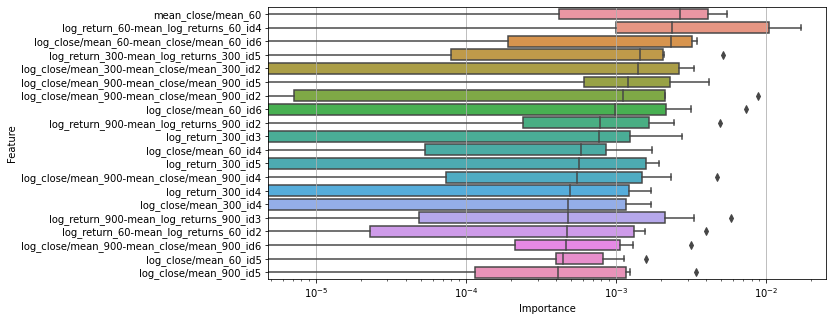

OOF corr score of BTCUSD (ID=0) is -0.00023. (Weight: 1.00000)


Training model for BTCUSDT          (ID=1 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123416
number of val data:   20569


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00426597	tr's corr: 0.0699326	vl's rmse: 0.00267164	vl's corr: -0.0277096
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold0.pkl'

doing split 2 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	tr's rmse: 0.00427773	tr's corr: 0.100484	vl's rmse: 0.00254747	vl's corr: -0.0160642
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold1.pkl'

doing split 3 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00387884	tr's corr: 0.0670822	vl's rmse: 0.00510559	vl's corr: -0.020977
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold2.pkl'

doing split 4 out of 7
number of train data:

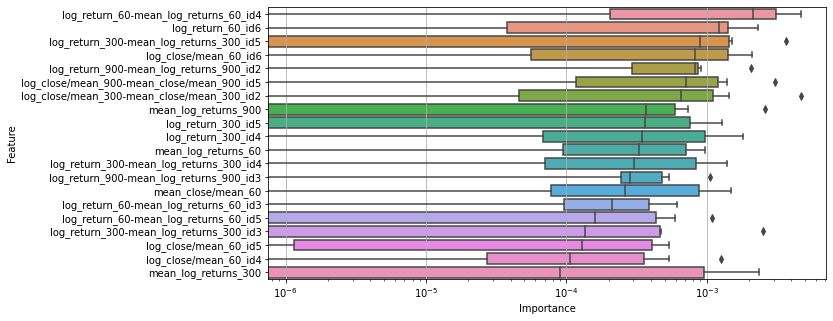

OOF corr score of BTCUSDT (ID=1) is -0.01306. (Weight: 1.00000)


Training model for ETHUSD           (ID=2 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123416
number of val data:   20569


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	tr's rmse: 0.00570891	tr's corr: 0.200603	vl's rmse: 0.0032039	vl's corr: 0.0290743
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold0.pkl'

doing split 2 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	tr's rmse: 0.00574537	tr's corr: 0.181006	vl's rmse: 0.00289926	vl's corr: 0.0336751
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold1.pkl'

doing split 3 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00515834	tr's corr: 0.274937	vl's rmse: 0.00647054	vl's corr: 0.0318081
Early stopping, best iteration is:
[112]	tr's rmse: 0.00515085	tr's corr: 0.280239	vl's rmse: 0.0064688	vl's corr: 0.0390744
Evaluated only: rmse
Trained model 

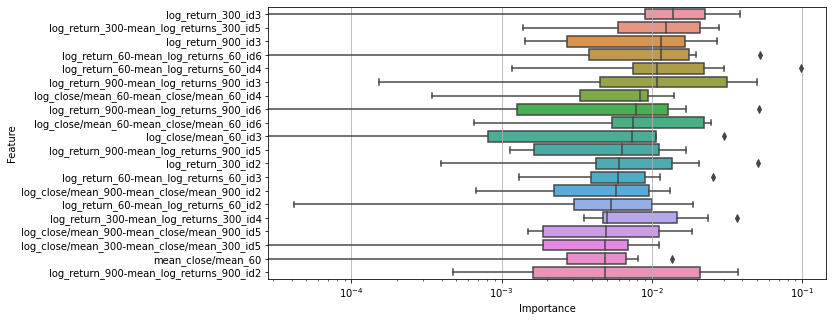

OOF corr score of ETHUSD (ID=2) is 0.02071. (Weight: 1.00000)


Training model for ETHUSDT          (ID=3 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123416
number of val data:   20569


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00566198	tr's corr: 0.122087	vl's rmse: 0.00318421	vl's corr: 0.00303411
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold0.pkl'

doing split 2 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	tr's rmse: 0.00568169	tr's corr: 0.172449	vl's rmse: 0.00289969	vl's corr: 0.0240791
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold1.pkl'

doing split 3 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	tr's rmse: 0.00519353	tr's corr: 0.193966	vl's rmse: 0.00631244	vl's corr: 0.0346452
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold2.pkl'

doing split 4 out of 7
number of train data: 1

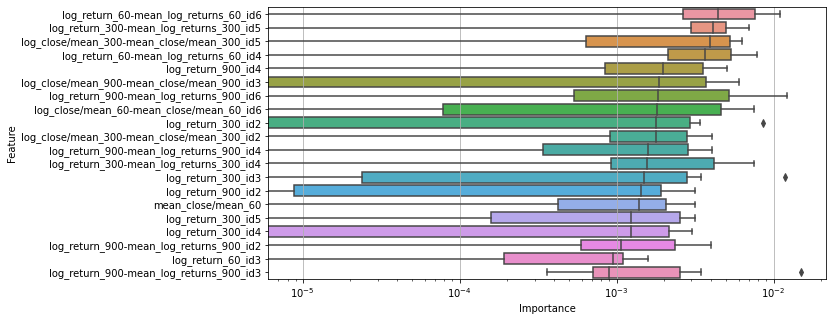

OOF corr score of ETHUSDT (ID=3) is 0.00521. (Weight: 1.00000)


Training model for XRPUSD           (ID=4 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123416
number of val data:   20569


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	tr's rmse: 0.00537976	tr's corr: 0.353675	vl's rmse: 0.00351287	vl's corr: 0.0423891
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold0.pkl'

doing split 2 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	tr's rmse: 0.0055194	tr's corr: 0.223214	vl's rmse: 0.00344473	vl's corr: 0.0159162
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold1.pkl'

doing split 3 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00449414	tr's corr: 0.0874811	vl's rmse: 0.00860915	vl's corr: 0.00566076
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold2.pkl'

doing split 4 out of 7
number of train data: 1

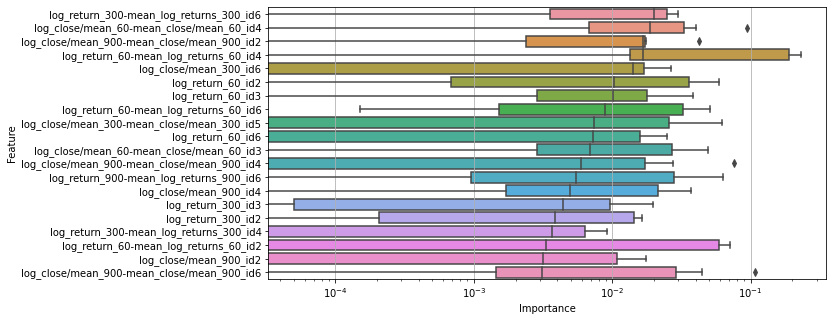

OOF corr score of XRPUSD (ID=4) is 0.02468. (Weight: 1.00000)


Training model for XRPUSDT          (ID=5 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123416
number of val data:   20569


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	tr's rmse: 0.00548251	tr's corr: 0.262252	vl's rmse: 0.00353237	vl's corr: 0.0196382
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold0.pkl'

doing split 2 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00550078	tr's corr: 0.145022	vl's rmse: 0.00347064	vl's corr: -0.0218671
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold1.pkl'

doing split 3 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	tr's rmse: 0.00450498	tr's corr: 0.14489	vl's rmse: 0.00847315	vl's corr: 0.0199346
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold2.pkl'

doing split 4 out of 7
number of train data: 123

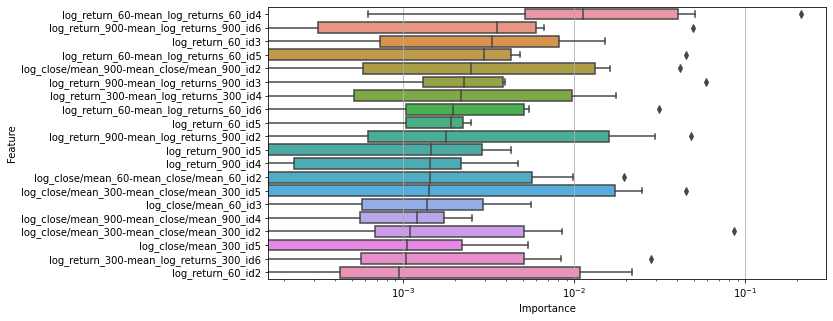

OOF corr score of XRPUSDT (ID=5) is 0.00426. (Weight: 1.00000)


Training model for SOLUSDT          (ID=6 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123416
number of val data:   20569


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	tr's rmse: 0.00809332	tr's corr: 0.300319	vl's rmse: 0.00589087	vl's corr: 0.0600743
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold0.pkl'

doing split 2 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	tr's rmse: 0.00831861	tr's corr: 0.27311	vl's rmse: 0.00404148	vl's corr: 0.0186636
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold1.pkl'

doing split 3 out of 7
number of train data: 123416
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00712499	tr's corr: 0.109202	vl's rmse: 0.0114563	vl's corr: 0.0186079
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold2.pkl'

doing split 4 out of 7
number of train data: 123

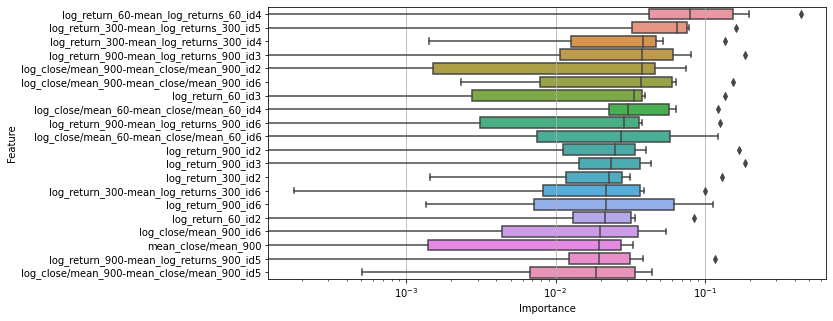

OOF corr score of SOLUSDT (ID=6) is 0.04575. (Weight: 1.00000)




In [153]:
oof = [ [] for id in range(NUM_OF_ASSETS)   ]

all_oof_pred = []
all_oof_valid = []
all_oof_weight = []

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    
    oof_pred, oof_valid = get_Xy_and_model_for_asset(feat, asset_id)
    
    weight_temp = float( df_asset_details.loc[  df_asset_details['Asset_ID'] == asset_id  , 'Weight'   ]  )
    
    all_oof_pred += oof_pred
    all_oof_valid += oof_valid
    all_oof_weight += [weight_temp] * len(oof_pred)
    
    oof[asset_id] = corr_score(     np.array(oof_pred)   ,    np.array(oof_valid)    )
    
    print(f'OOF corr score of {asset_name} (ID={asset_id}) is {oof[asset_id]:.5f}. (Weight: {float(weight_temp):.5f})')
    print('')
    print('')

In [154]:
woof = 0
for id in range(NUM_OF_ASSETS):
    woof += oof[id] * float(  df_asset_details.loc[  df_asset_details['Asset_ID'] == id  , 'Weight'   ] )
woof = woof / df_asset_details['Weight'].sum()

print(f'OOF corr scores are;')
for oof_score in oof:
    print(f'      {oof_score:.5f}')
print(f'  simple average corr score: {np.mean(oof):.5f}.')
print(f'weighted average corr score: {woof:.5f}.')
print(f'')

all_oof_wcorr = wcorr_score(     np.array(all_oof_pred),    np.array(all_oof_valid),  np.array(all_oof_weight)   )
print(f'        weighted corr score: {all_oof_wcorr:.5f}.')

OOF corr scores are;
      -0.00023
      -0.01306
      0.02071
      0.00521
      0.02468
      0.00426
      0.04575
  simple average corr score: 0.01247.
weighted average corr score: 0.01247.

        weighted corr score: 0.02587.
